Problem 2: Structure Learning using the Chow-Liu Algorithm
 
 We have a 5-dimensional joint distribution:
 
 $$ 
 p(x_1, x_2, x_3, x_4, x_5) = p(x_1) \times p(x_2 \mid x_1) \times p(x_3 \mid x_1, x_2) \times p(x_4 \mid x_2) \times p(x_5 \mid x_2, x_3).
 $$
 
 In more detail, each factor is a Normal distribution:
 - $x_1 \sim \mathcal{N}(0,\,1)$.
 - $x_2 \mid x_1 \sim \mathcal{N}(x_1,\;2)$.
 - $x_3 \mid x_1, x_2 \sim \mathcal{N}(x_1 + x_2^2,\; x_1^2 + 1)$.
 - $x_4 \mid x_2 \sim \mathcal{N}(2\,x_2,\; 4)$.
 - $x_5 \mid x_2, x_3 \sim \mathcal{N}(x_3 + x_2^2,\; x_2^2 + 1)$.
 
 (a) Draw the Bayesian Network for this joint distribution
 From the factorization, the directed edges are:
 
 - $x_1 \to x_2$
 - $x_1 \to x_3$ and $x_2 \to x_3$
 - $x_2 \to x_4$
 - $x_2 \to x_5$ and $x_3 \to x_5$
 
 Graphically (arrows showing dependence):
 
 ```
 x_1
  |
  v
 x_2 -> x_3
  |      |
  v      v
 x_4    x_5
 ```
 
 (b) Which 2 edges can we drop to have a **first‐order dependency tree**?
 A first‐order dependency tree means **each node has at most one parent**, producing exactly 4 edges for 5 nodes in a singly‐connected structure.  
 
 Out of the 6 edges ($x_1 \to x_2$, $x_1 \to x_3$, $x_2 \to x_3$, $x_2 \to x_4$, $x_2 \to x_5$, $x_3 \to x_5$), we can drop two so that each node has at most one parent.  For instance, one alid choice is to keep:
 
 1. $x_1 \to x_2$
 2. $x_2 \to x_3$
 3. $x_2 \to x_4$
 4. $x_3 \to x_5$
 
 …and **drop** $\{x_1 \to x_3,\; x_2 \to x_5\}$.
 
 (You could pick a different subset that yields a spanning‐tree structure, as long as every node ends up with exactly one parent except for a designated root.)
 
 (c) Generate samples, apply Chow‐Liu, and draw the learned tree
 We now do this **empirically**: 
 1. Generate $N$ samples from the above continuous distributions,  
 2. Estimate the mutual information among each pair of $\{x_1,\dots,x_5\}$ via a discrete‐binning approach,  
 3. Build a **maximum‐spanning tree** on the 5 variables (equivalently, a *minimum*‐spanning‐tree on the negative MI),  
 4. Compare the learned edges to the original BN.

Chow-Liu edges (variable indices, 0-based):
0 -- 1   (MI=0.222)
1 -- 4   (MI=0.798)
1 -- 3   (MI=0.684)
2 -- 4   (MI=0.883)


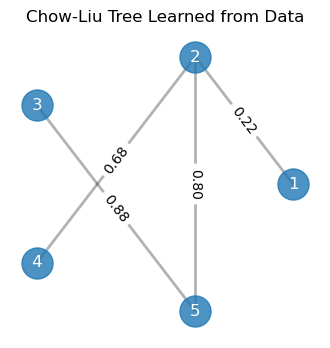

In [1]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt



def sample_data(n_samples=10000, seed=0):
    """
    Generates samples (x1, x2, x3, x4, x5) from:
      x1 ~ N(0,1)
      x2 | x1 ~ N(x1, 2)
      x3 | x1,x2 ~ N(x1 + x2^2, x1^2 + 1)
      x4 | x2 ~ N(2*x2, 4)
      x5 | x2,x3 ~ N(x3 + x2^2, x2^2 + 1)
    Returns an (n_samples, 5) NumPy array.
    """
    torch.manual_seed(seed)
    x1 = torch.randn(n_samples)  # Normal(0,1)
    
    # x2 | x1
    # mean = x1, var=2
    eps2 = torch.sqrt(torch.tensor(2.0)) * torch.randn(n_samples)
    x2 = x1 + eps2
    
    # x3 | x1, x2
    # mean = x1 + x2^2, var= x1^2 + 1
    # We must handle var > 0 carefully since x1^2 + 1 is always >= 1
    eps3 = torch.randn(n_samples)
    x3_var = x1**2 + 1.0
    x3 = (x1 + x2**2) + eps3 * torch.sqrt(x3_var)
    
    # x4 | x2
    # mean = 2*x2, var=4
    eps4 = 2.0 * torch.randn(n_samples)  # since var=4 => std=2
    x4 = 2.0*x2 + eps4
    
    # x5 | x2, x3
    # mean = x3 + x2^2, var= x2^2 + 1
    eps5 = torch.randn(n_samples)
    x5_var = x2**2 + 1.0
    x5 = (x3 + x2**2) + eps5 * torch.sqrt(x5_var)
    
    # Stack into shape (N,5)
    data = torch.stack([x1, x2, x3, x4, x5], dim=1)
    return data.numpy()

data = sample_data(n_samples=10000, seed=42)

##############################################
# 2) ESTIMATE MUTUAL INFORMATION
#    (Using a 2D-histogram binning approach)
##############################################

def approximate_mi(x, y, num_bins=30):
    """
    Approximate the mutual information between two 1D continuous variables x,y
    using histogram binning.
    """
    # 2D histogram
    counts_xy, xedges, yedges = np.histogram2d(x, y, bins=num_bins)
    
    # Convert counts to probabilities
    p_xy = counts_xy / np.sum(counts_xy)
    # Marginals
    p_x = np.sum(p_xy, axis=1, keepdims=True)
    p_y = np.sum(p_xy, axis=0, keepdims=True)
    
    # Avoid log(0) by adding a small epsilon
    eps = 1e-12
    p_xy_safe = p_xy + eps
    p_x_safe  = p_x  + eps
    p_y_safe  = p_y  + eps
    
    # MI = sum p(x,y) log [ p(x,y) / (p(x)*p(y)) ]
    mi = np.sum( p_xy_safe * np.log( p_xy_safe / (p_x_safe*p_y_safe) ) )
    return mi

##############################################
# 3) BUILD A MAXIMUM-SPANNING TREE (CHOW-LIU)
##############################################

# We'll treat each variable index {0,1,2,3,4} = {x1, x2, x3, x4, x5}.
# For each pair i,j, compute approximate MI.
p = data.shape[1]  # 5
mi_matrix = np.zeros((p,p))

for i in range(p):
    for j in range(i+1, p):
        mi_val = approximate_mi(data[:,i], data[:,j], num_bins=30)
        mi_matrix[i,j] = mi_val
        mi_matrix[j,i] = mi_val

# We want a "maximum spanning tree" in terms of MI,
# i.e. we want edges that maximize MI.  NetworkX only has
# a *minimum* spanning tree out-of-the-box, so we can store
# negative MI as the weight => MST gives maximum MI edges.
G = nx.Graph()
for i in range(p):
    G.add_node(i)

for i in range(p):
    for j in range(i+1, p):
        w = -mi_matrix[i,j]  # negative => MST => maximum
        G.add_edge(i, j, weight=w)

mst = nx.minimum_spanning_tree(G)  # yields edges that maximize MI

# The resulting tree is the Chow-Liu dependency tree.
print("Chow-Liu edges (variable indices, 0-based):")
for (u,v) in mst.edges():
    print(f"{u} -- {v}   (MI={mi_matrix[u,v]:.3f})")

##############################################
# 4) DRAW THE LEARNED TREE
##############################################
pos = nx.circular_layout(mst)
plt.figure(figsize=(4,4))
nx.draw_networkx_nodes(mst, pos, node_size=500, alpha=0.8)
nx.draw_networkx_labels(mst, pos, 
                        labels={i:str(i+1) for i in range(p)}, # label them x1..x5
                        font_size=12, font_color='white')

# convert weight=-MI => label=+MI
edge_labels = {(u,v):f"{mi_matrix[u,v]:.2f}" for (u,v) in mst.edges()}
nx.draw_networkx_edges(mst, pos, width=2, alpha=0.3)
nx.draw_networkx_edge_labels(mst, pos, edge_labels=edge_labels)

plt.title("Chow-Liu Tree Learned from Data")
plt.axis("off")
plt.show()
